<a href="https://colab.research.google.com/github/vgarcialopezm/ABC-SMC/blob/main/ABCSMCIMPEUL_mas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import norm, uniform, multivariate_normal
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.special import logsumexp
from scipy import sparse as sp
import sys,ast
from math import exp,log
from random import choices,seed,random
from tqdm import tqdm
#import p_tqdm
from functools import partial
import os
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spl



In [2]:
epsilons=[400.0,300.0,200.0,100.0,80.0] #200.0,150.0,125.0,115.0] #105.0] #,100.0,94.0,90.0,87.0]
#epsilons=[50000.0,40000.0,30000.0,25000.0,20000]
#epsilons=[16.0,12.0,11.8,11.3,10.6,7.1,5.2]


#PARAMETERS INVOLVED IN THE GLIOBLASTOMA MODEL

params_tumor = [ # list of parameters used in the glioblastoma model 
    {'name' : 'Dn', 'lower_limit':0.004,'upper_limit':0.01},# Population of cells Diffusion coefficient
    {'name' : 'Dc','lower_limit':70.0,'upper_limit':150.0},# Oxygen Diffusion coefficient 
    {'name' : 'am','lower_limit':21000.0,'upper_limit':28000.0},# term involved in the calculation of a(G1/S)
    {'name' : 'k1','lower_limit':1.0,'upper_limit':3.0}, #Oxygen consumption rate,
    {'name' : 'betaf','lower_limit':40.0,'upper_limit':50.0}, #flow of oxygen at right boundary
    {'name' : 'beta','lower_limit':0.2,'upper_limit':0.5}, #flow of oxygen at right boundary
    {'name' : 'nu','lower_limit':0.000001,'upper_limit':0.0001} #flow of oxygen at right boundary

]

In [3]:
taup=4800   #*deltat  #*deltat
beta1=2.5
a3H0=0.0085
d1=0.2
a0=0.45185
a1=0.51
a2=1
d2=0.1
e2f=1
#beta=0.4980
#value of p6/p3 set to 1
p6p3=1
#c critico
# Calculate the value of c_cr using the parameters above and the expression given in the document
#ccr=1.0-((1.0/beta1)*np.log((1/a3H0)*(a1+((a2*d2)/(d1*e2f))*(1-1/(1-a0/((p6p3)*(p6p3)))))));
#nu=0.00001097


In [4]:
#spatial grid
L=191
dx=0.4819 #0.4819 #J/(L)
J=dx*L
x_grid=np.linspace(0,J,L)
#time grid
T=3*24*3600 #3 #final time (3 days)
dt=1000
N=round((1/dt)*T) #300  #501  #NUMBER OF TIME STEPS
 #time step (it is almost every 130 secs. 2 minutes approximately)
t_grid=np.linspace(0,T,N)
#k1=1.45773318
k2=0.0942

#parameters involved in Newton Raphson method:
max_iter=20
tolerance=0.00001

In [5]:
datos = np.loadtxt('doblaredia3.txt', delimiter=',')
len(datos)

191

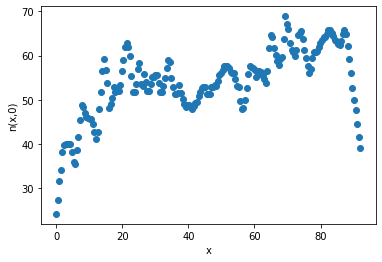

In [6]:
U=datos
plt.plot(x_grid, U,'o')
plt.xlabel('x')
plt.ylabel('n(x,0)')
plt.show()

In [11]:
datosdia6 = np.loadtxt('datosdia6.txt', delimiter=',')
len(datosdia6)

191

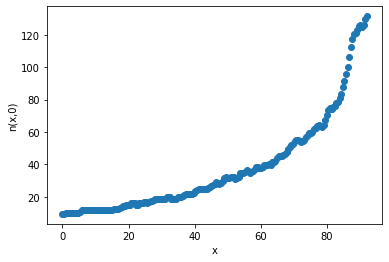

In [12]:
plt.plot(x_grid, datosdia6,'o')
plt.xlabel('x')
plt.ylabel('n(x,0)')
plt.show()

In [13]:
datosdia9=np.loadtxt('datosdia9.txt', delimiter=',')

OSError: ignored

In [14]:
def newton_raps(c,am,ccr,nu,beta):
    #print('c',c)
    if c>ccr:
      aG1S=am*(c/ccr-1)**(-beta)
    else:
      aG1S=10000000000
    #print(aG1S)
    #print('ag1s',aG1S)
    #Expression of the function to obtain the value of lambda
    f=lambda lam:log(taup)-log(2)+lam*aG1S+nu*aG1S+log(lam+nu+1/taup)
  
    #Fist derivative of th previos function 
    Df=lambda lam: aG1S+1/(lam+nu+1/taup)
    #tabla = []
    section = abs(2*tolerance)
    xi = 0
    while (section>=tolerance):
        xnew = xi - f(xi)/Df(xi)
        section  = abs(xnew-xi)
        #tabla.append([xi,xnew,section])
        xi = xnew
    return xi
#xi=newton_raps(c)


In [15]:
def crank_nic(Dn,Dc,a_m,U,L,k1,betaf):
    sigma_u=Dn*dt/(dx**2)
    sigma_v=Dc*dt/(dx**2)
    c_est=Dc*betaf/(L*(k1*np.mean(U)+k2))
    aux=np.zeros(L)
    aux[-1]= 4*dx*betaf*sigma_v
    
    V = np.array([c_est for i in range (0,L)])
    aux=np.zeros(L)
    aux[-1]= 4*dx*betaf*sigma_v
    #Matrices for Crank Nicholson in equation of population of cells
    #diagonals=[L*[2.+2.*sigma_u] ,[-2.*sigma_u,(L-2)*[-sigma_u]],[(L-2)*[-sigma_u],-2*sigma_u]]
    #A_n=sparse.diags(diagonals,[0,1,-1]).toarray()
    A_n = np.diagflat([-sigma_u for i in range(L-2)]+[-2*sigma_u], -1) +\
      np.diagflat([2.+2.*sigma_u for i in range(L)]) +\
      np.diagflat([-2.*sigma_u]+[-sigma_u for i in range(L-2)], 1)
    A_n=sp.csr_matrix(A_n)
    B_n = np.diagflat([sigma_u for i in range(L-2)]+[2.*sigma_u], -1) +\
      np.diagflat([2.-2.*sigma_u for i in range(L)]) +\
      np.diagflat([2.*sigma_u]+[sigma_u for i in range(L-2)], 1)
    B_n=sp.csr_matrix(A_n)
    #Matrices for Crank Nicholson in equation of oxygen
    A_c = np.diagflat([-sigma_v for i in range(L-2)]+[-2*sigma_v], -1) +\
      np.diagflat([2.+2.*sigma_v for i in range(L)]) +\
      np.diagflat([-2.*sigma_v]+[-sigma_v for i in range(L-2)], 1)
    A_c=sp.csr_matrix(A_c)
    B_c = np.diagflat([sigma_v for i in range(L-2)]+[2.*sigma_v], -1) +\
      np.diagflat([2.-2.*sigma_v for i in range(L)]) +\
      np.diagflat([2.*sigma_v]+[sigma_v for i in range(L-2)], 1)
    B_c=sp.csr_matrix(B_c) 
  
    
    for ti in range(1,N):
        lamda_vect=np.zeros(L)
        for i in range(L):
            xi=newton_raps(V[i],a_m)
            lamda_vect[i]=xi #np.longfloat(xi)
        #print('step',ti)
        U_new = spl.spsolve(A_n, (B_n @ U + dt*lamda_vect*U))
        V_new = spl.spsolve(A_c, (B_c@V +dt*(-k1*U*V-k2*V+aux)))
        lamda_vect=np.zeros(L)
        V = V_new
        #print(V_new)
        #for i in range(L):
        #    xi=newton_rapsi(V[i],a_m,nu)
        #    lamda_vect[i]=np.longfloat(xi)
        #print(lamda_vect)
        U = U_new
        #print(U_new)
    #print(V_new)
    return U,V 

In [16]:
def valores(Dc,k1,k2,betaf):
  c_est=Dc*betaf/(L*(k1*np.mean(datos)+k2))
  x0=np.zeros(382)
  for i in range (0,len(datos)):
     x0[i]=datos[i]
  for j in range(len(datos),382):
     x0[j]=c_est
  return x0

In [28]:
from scipy.interpolate.interpolate import interp2d
from numpy.lib.function_base import iterable
def eval_function(x,Dn,Dc,c1,am,betaf,ccr,nu,beta):
  #c2=(9.42*10**(-2))
  #x=valores(Dc,c1,c2)
  iter=np.zeros(382)
  sigma_n=Dn/(dx**2)
  sigma_c=Dc/(dx**2)
  iter[0]=(sigma_n)*(2*x[1]-2*x[0])+newton_raps(x[191],am,ccr,nu,beta)*x[0]
  for i in range (1,190):
    iter[i]=(sigma_n)*(x[i-1]-2*x[i]+x[i+1])+newton_raps(x[i+190],am,ccr,nu,beta)*x[i]
  iter[190]=(sigma_n)*(2*x[189]-2*x[190])+newton_raps(x[381],am,ccr,nu,beta)*x[190]
  iter[191]= (sigma_c)*(2*x[192]-2*x[191])-c1*x[0]*x[191]-k2*x[191]
  for j in range(192,381):
        iter[j]= (sigma_c)*(x[j-1]-2*x[j]+x[j+1])-c1*x[j-192]*x[j]-k2*x[j]
  iter[381]=(sigma_c)*((2*x[380]-2*x[381])+2*betaf*dx)-c1*x[190]*x[381]-k2*x[381]

  return iter      



In [29]:
#h=0.4819
#c2=(9.42*10**(-2))
def euler_imp(Dn,Dc,am,k1,betaf,beta,nu):
  ccr=1.0-((1.0/beta1)*np.log((1/a3H0)*(a1+((a2*d2)/(d1*e2f))*(1-1/(1-a0/((p6p3)*(p6p3)))))));
  x0=valores(Dc,k1,k2,betaf)
  prev_iter=x0
  x=x0
  #dt=1000 #TIME STEP IN SECONDS
  sol=np.zeros(382)
  #T=259200; #NUMBER OF SECONDS IN THREE DAYS


  #nsteps=round((1/dt)*T); #%VOY A DAR 867 pasos

  func=lambda x: x-dt*eval_function(x,Dn,Dc,k1,am,betaf,ccr,nu,beta)-prev_iter

  for i in range(0,N):
    sol=fsolve(func,prev_iter)
    prev_iter=sol
  return(sol)


In [ ]:
euler_imp(0.002,60,13778.24,8.27,42.12)

KeyboardInterrupt: ignored

In [19]:
def euc_disti(data1, data2):
    if np.shape(data1) != np.shape(data2):
        print ("\n the dimensions of the datasets are different (%s v.s. %s)\n" % (len(data1), len(data2)))
        sys.exit()
    else:
        distance = np.linalg.norm(data1 - data2)
        #print('dist',data1 - data2)

    if distance < 0:
        return [None]
    else:
        return distance


In [20]:
def euc_dist(data1, data2):
    if np.shape(data1) != np.shape(data2):
        print ("\n the dimensions of the datasets are different (%s v.s. %s)\n" % (len(data1), len(data2)))
        sys.exit()
    else:
        z=np.array((data1 - data2)**2)
        distance = np.sum(z)
        #print('dist',data1 - data2)

    if distance < 0:
        return [None]
    elif np.isnan(distance):
        distance=100000
        return distance
    else:
        return distance


In [21]:
def prior():
### Generate a random parameter inside the limits stablished. The shape of the distribution can be changed if required
    prior = []
    for ipar,par in enumerate(params_tumor):
        prior.append(uniform.rvs(loc = par['lower_limit'],
                                 scale = par['upper_limit']-par['lower_limit'])) #par['upper_limit']))
        
       
    return prior


In [22]:
#function that given the values of the parameters, calculates the 

def evaluate_prev_pru(params):
    print('parameters',params)
    l=len(params)
    prior = 1
    for ipar,par in enumerate(params_tumor):
    #for i in range(l):
        prior *= uniform.pdf(params[ipar],loc = par['lower_limit'],
                                 scale = par['upper_limit']-par['lower_limit'])
        if prior==0:
            break   
      #  print('params i', params[i])
       # print('prior',prior)
    return prior


In [23]:
#function that, given a list of parameters sampled, perturbs it by applying a multivariate normal kernel
def perturb(listaprev,s):
    print(listaprev)
    lista=np.asarray(listaprev) #.tolist()
    #mean_vec=np.mean(lista)
    cov_matrix=2.0*np.cov(lista.T)  #the covariance matrix for the multivariate normal perturbation kernel is given by this expression
    print(cov_matrix)
    kernel=multivariate_normal(cov=cov_matrix,allow_singular=True)
    pert=s+kernel.rvs() # here we obtain the list of perturbed parameters
    pertur=pert.tolist()
    return pertur


In [24]:
#function that gives the denominator used to calculate the weights of every particle.
def weighting(i,j,N,sam,wei,sampre):
     denom=0
     #ker=1
     samprev=np.asarray(sampre)
     cov_matrix=2.0*np.cov(samprev)
     kernel=multivariate_normal(cov=cov_matrix,allow_singular=True)
     for k in range(N):
            #print('sample i j',type(sam[k]),sam[k])
           # print('sample i-1,j',type(sampre[k]),sampre[k])
            sampre[k]=np.array(sampre[k])
            #print('sampre',sampre[k])
            #cov_matrix=2.0*np.cov((sampre[k]).T)  #the covariance matrix for the multivariate normal perturbation kernel is given by this expression
            #print('cov',cov_matrix)
            #kernel=multivariate_normal(cov=cov_matrix)
            # print('wei',wei[i-1,k])
            #print('sam[j]',sam[j])
            #print('sampre[k]',sampre[k])
            ker=kernel.pdf(sam[j]-sampre[k])
            #print('ker',ker)
            #kerne=np.prod(ker)  #here we are obtaining the joint probability of the parameter vector obtained when applying the kernel
            denom+=wei[k]*ker #kerne
            #print('kernel',kernel.cdf(sam[k]-sampre[k]))
     #print('den',denom)      
     return denom


In [25]:
#function used to normalize the weights
def normalize(wei):
    #normalized=wei/np.linalg.norm(wei)
    normalized=wei/np.sum(wei)
    return normalized  



In [26]:
def principal(epsilons,listaparametros,N,data1):
   # accepted_distances = np.loadtxt('smc/distances_{}_{}_{}_{}.out'.format(model,sto,gamma,prior_label))
    T=len(epsilons)
    weight=np.zeros((T,N),float)
    dist=np.zeros((T,N),float)
    sample=np.zeros((T,N),list)
    #X0=[Ui,Vi]
    #t=np.linspace(0.,10,10)
    for i in range(T):
        count=0
        counti=0
        label=i
        print("SMC step with target distance: {}".format(epsilons[i]))
        if i==0:
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    sample[i,j]=prior()
                    #sample[i,j]=np.array(prior())
                    sample[i,j]=np.asarray(sample[i,j])
                    print(sample[i,j][0])
                    print(sample[i,j][1])
                    print(sample[i,j][2])
                    print(sample[i,j][3])
                    print(sample[i,j][4])
                    print(sample[i,j][5])
                    print(sample[i,j][6])
                    #print(sample[i,j][5])
                    data2= euler_imp(sample[i,j][0],sample[i,j][1],sample[i,j][2],sample[i,j][3],sample[i,j][4],sample[i,j][5],sample[i,j][6]).T#,sample[i,j][5])
                    oxi=np.zeros(191)
                    oxi=data2[191:]
                    print('oxigeno',oxi)
                    data_2=np.zeros(191)
                    data_2=np.array(data2[0:191])
                    print('data2',data_2)
                    print('data1',data1)
                    #print('data2',data2)
                    #data2=np.array(data2, dtype=np.float64)
                    dist[i,j]=euc_disti(data1,data_2)
                    print('distcondata2',dist[i,j])
                    plt.plot(x_grid,datosdia6)
                    plt.plot(x_grid,data_2)
                    plt.xlabel('x')
                    plt.ylabel('n(x,T)')
                    plt.legend(loc="upper left")
                    plt.show()
                count+=1
                print(count)
       
        else:
        
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    seed()
                    np.random.seed()
                    choose = choices(sample[i-1,:], weights = weight[i-1,:],k=1)[0] # select a point from the previous sample
                    sample[i,j]=choose
                    #print("before perturb",type(sample[i,j]))
                    #print("before perturb",list(sample[i-1,:]))
                    sample[i,j] = perturb(list(sample[i-1,:]),sample[i,j]) # and perturb it
                    print("after perturb", sample[i,j])
                    #print("after perturb", type(sample[i,j]))
                    evaluation=evaluate_prev_pru(sample[i,j]) 
                    if evaluation>0:
                        data2= np.array(euler_imp(sample[i,j][0],sample[i,j][1],sample[i,j][2],sample[i,j][3],sample[i,j][4],sample[i,j][5],sample[i,j][6])).T #,sample[i,j][5])).T
                        oxi=np.zeros(191)
                        oxi=data2[191:]
                        print('oxigeno',oxi)
                        data_2=np.zeros(191)
                        data_2=np.array(data2[0:191])
                        print('data2',data_2)
                        print('data1',data1)
                        dist[i,j]=euc_disti(data1,data_2)
                        print('distendata2',dist[i,j])
                        plt.plot(x_grid,datosdia6)
                        plt.plot(x_grid,data_2)
                        plt.xlabel('x')
                        plt.ylabel('n(x,T)')
                        plt.legend(loc="upper left")
                        plt.show()
                counti+=1
                print(counti)
        for j in range(N):
            if i==0:
                weight[i,j]=1
               # print(weight[i,j])
            elif i==T-1:
              break
            else:
                denom=weighting(i,j,N,sample[i,:],weight[i-1,:],list(sample[i-1,:]))
                weight[i,j]=evaluate_prev_pru(sample[i,j])/denom
        #print('weight[i,:]',weight[i,:])
        if i!=0:
           weight[i,:]=normalize(weight[i,:])
           #print('weight[i,:] normalized',weight[i,:])
        #pars = np.loadtxt('smc_van/pars_{}.out'.format(i))
        #weights = np.loadtxt('smc_van/weights_{}.out'.format(i))
        #np.savetxt('smc_van/pars_{}.out'.format(i), sample[T-1,:])
        #np.savetxt('smc_van/weights_{}.out'.format(i), weight[T-1,:])
      #  np.savetxt('smc/distances_{}.out'.format(label), accepted_distances)
    #print('sample',sample[T-1,N-1])
    #print('weight',weight[T-1])
    #print('dist',dist[T-1])
    return sample, weight, dist,data2


In [ ]:
def principal_cr(epsilons,listaparametros,N,data1):
   # accepted_distances = np.loadtxt('smc/distances_{}_{}_{}_{}.out'.format(model,sto,gamma,prior_label))
    T=len(epsilons)
    weight=np.zeros((T,N),float)
    dist=np.zeros((T,N),float)
    sample=np.zeros((T,N),list)
    #X0=[Ui,Vi]
    #t=np.linspace(0.,10,10)
    for i in range(T):
        count=0
        counti=0
        label=i
        print("SMC step with target distance: {}".format(epsilons[i]))
        if i==0:
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    sample[i,j]=prior()
                    #sample[i,j]=np.array(prior())
                    sample[i,j]=np.asarray(sample[i,j])
                    print(sample[i,j][0])
                    print(sample[i,j][1])
                    print(sample[i,j][2])
                    print(sample[i,j][3])
                    print(sample[i,j][4])
                    #print(sample[i,j][5])
                    data2= np.array(crank_nic(sample[i,j][0],sample[i,j][1],sample[i,j][2],U,L,sample[i,j][3],sample[i,j][4])).T#,sample[i,j][5])).T
                    print('oxigeno',data2[:,1])
                    data2=np.array(data2[:,0])
                    print('data2',data2)
                    print('data1',data1)
                    #print('data2',data2)
                    #data2=np.array(data2, dtype=np.float64)
                    dist[i,j]=euc_disti(data1,data2)
                    print('distcondata2',dist[i,j])
                    plt.plot(x_grid,datosdia6,'o')
                    plt.plot(x_grid,data2)
                    plt.xlabel('x')
                    plt.ylabel('n(x,T)')
                    plt.show()
                count+=1
                print(count)
       
        else:
        
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    seed()
                    np.random.seed()
                    choose = choices(sample[i-1,:], weights = weight[i-1,:],k=1)[0] # select a point from the previous sample
                    sample[i,j]=choose
                    #print("before perturb",type(sample[i,j]))
                    #print("before perturb",list(sample[i-1,:]))
                    sample[i,j] = perturb(list(sample[i-1,:]),sample[i,j]) # and perturb it
                    print("after perturb", sample[i,j])
                    #print("after perturb", type(sample[i,j]))
                    evaluation=evaluate_prev_pru(sample[i,j]) 
                    if evaluation>0:
                        data2= np.array(crank_nic(sample[i,j][0],sample[i,j][1],sample[i,j][2],U,L,sample[i,j][3],sample[i,j][4])).T #,sample[i,j][5])).T
                        print('oxigeno',data2[:,1])
                        data2=np.array(data2[:,0])
                        print('data2',data2)
                        print('data1',data1)
                        dist[i,j]=euc_disti(data1,data2)
                        print('distendata2',dist[i,j])
                        plt.plot(x_grid,datosdia6,'o')
                        plt.plot(x_grid,data2)
                        plt.xlabel('x')
                        plt.ylabel('n(x,T)')
                        plt.show()
                counti+=1
                print(counti)
        for j in range(N):
            if i==0:
                weight[i,j]=1
               # print(weight[i,j])
            elif i==T-1:
              break
            else:
                denom=weighting(i,j,N,sample[i,:],weight[i-1,:],list(sample[i-1,:]))
                weight[i,j]=evaluate_prev_pru(sample[i,j])/denom
        #print('weight[i,:]',weight[i,:])
        if i!=0:
           weight[i,:]=normalize(weight[i,:])
           #print('weight[i,:] normalized',weight[i,:])
        #pars = np.loadtxt('smc_van/pars_{}.out'.format(i))
        #weights = np.loadtxt('smc_van/weights_{}.out'.format(i))
        #np.savetxt('smc_van/pars_{}.out'.format(i), sample[T-1,:])
        #np.savetxt('smc_van/weights_{}.out'.format(i), weight[T-1,:])
      #  np.savetxt('smc/distances_{}.out'.format(label), accepted_distances)
    #print('sample',sample[T-1,N-1])
    #print('weight',weight[T-1])
    #print('dist',dist[T-1])
    return sample, weight, dist,data2


In [31]:
sample,weight,dist,data2=principal(epsilons,params_tumor,5,datosdia6)

SMC step with target distance: 400.0
0.006979953816565887
101.92848161665248
23039.021401086142
1.1133718289909478
41.336132253320585
0.20161623713272625
7.586622497154506e-05


KeyboardInterrupt: ignored

In [ ]:
print("min accepted distance: ",np.min(dist[-1,:]))

min accepted distance:  74.16216578625183


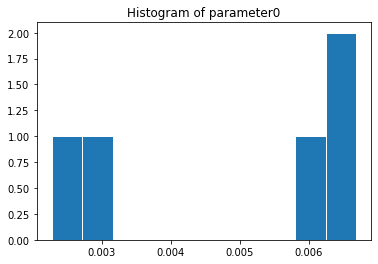

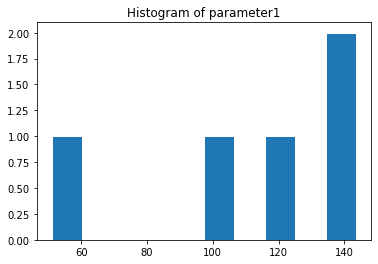

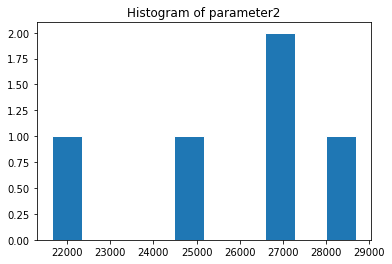

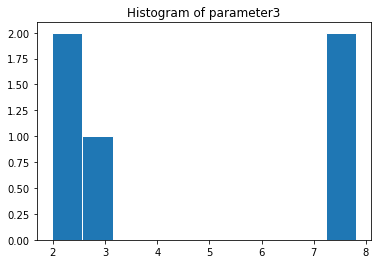

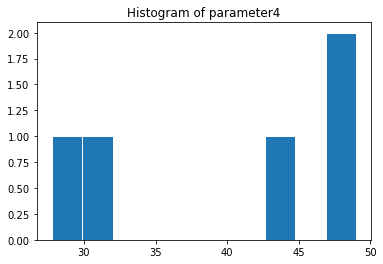

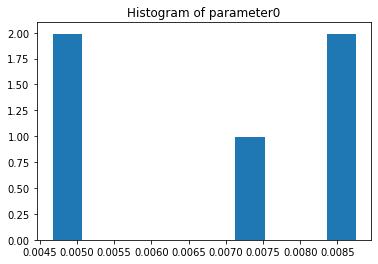

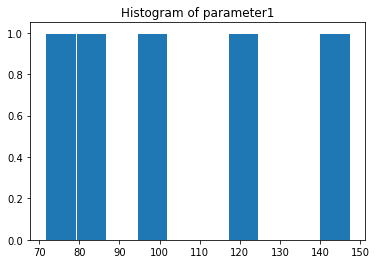

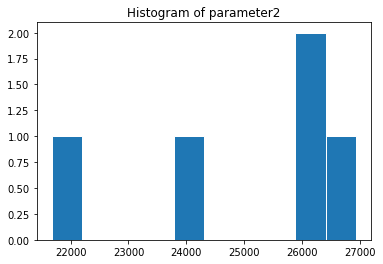

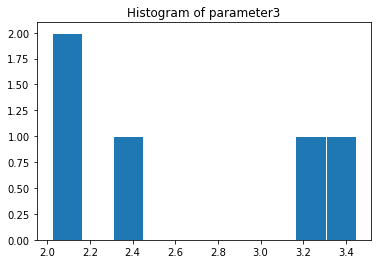

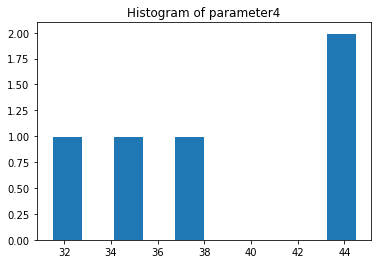

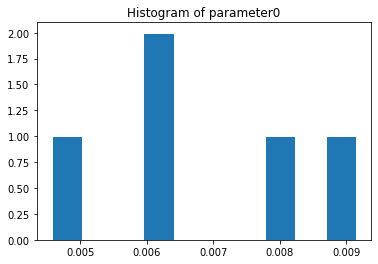

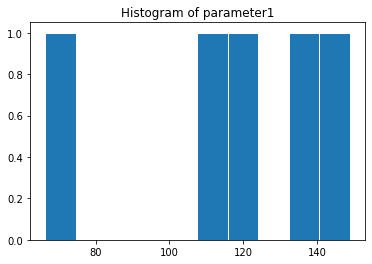

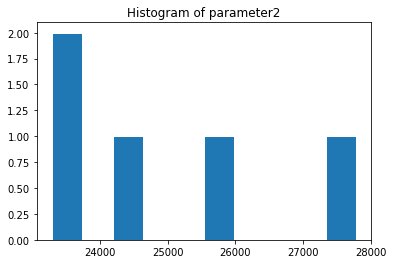

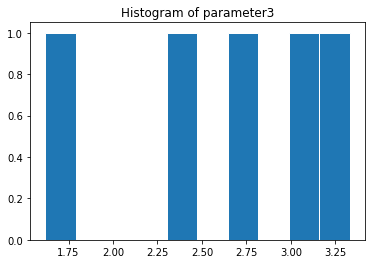

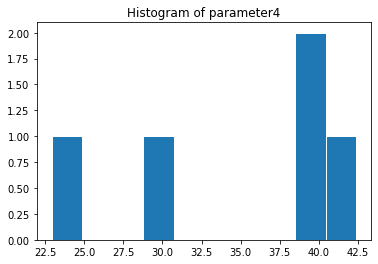

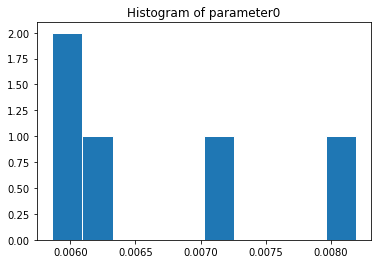

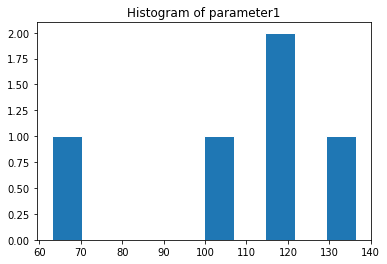

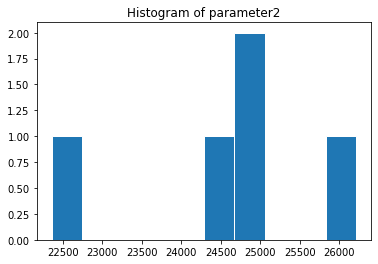

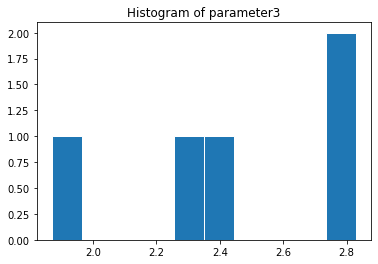

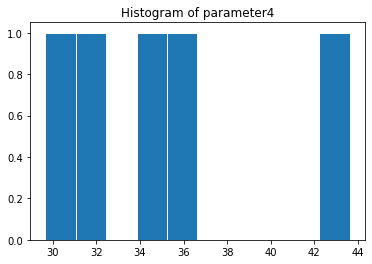

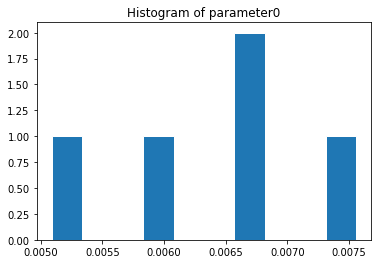

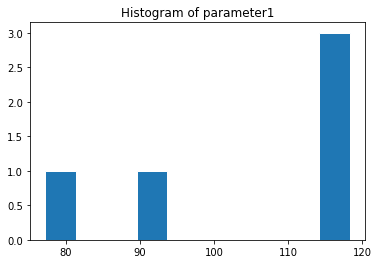

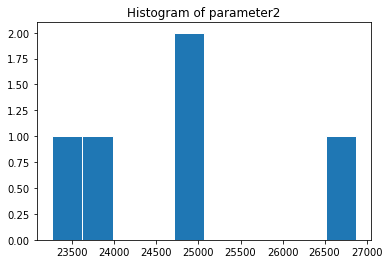

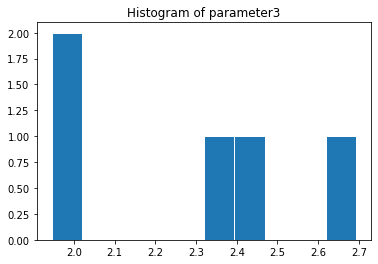

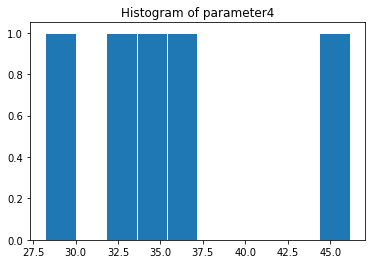

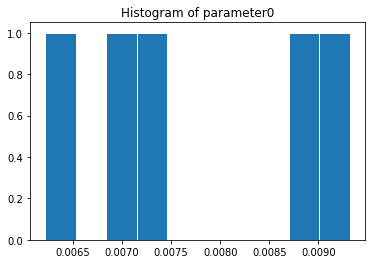

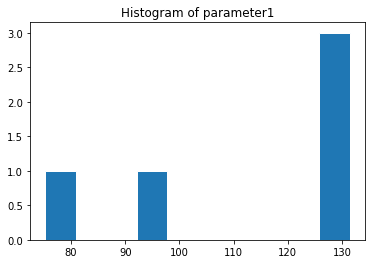

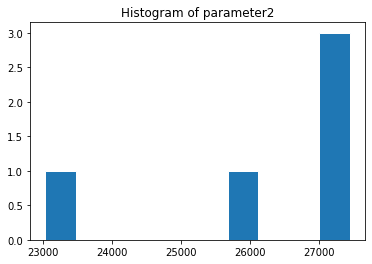

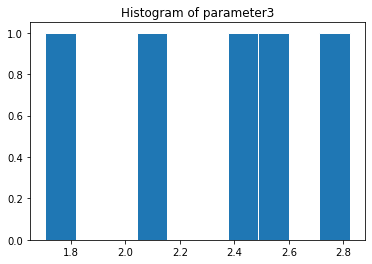

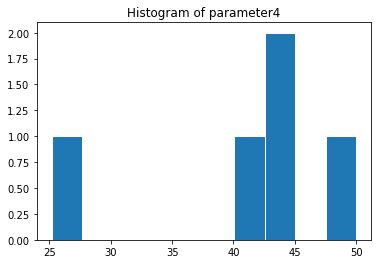

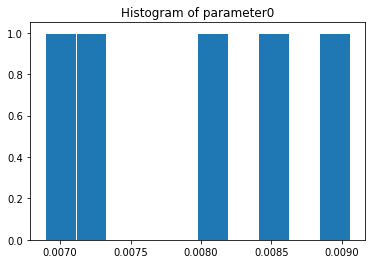

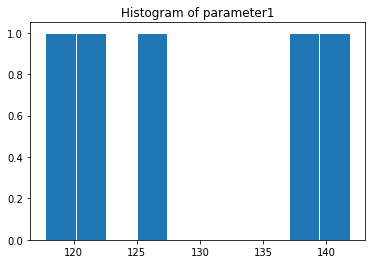

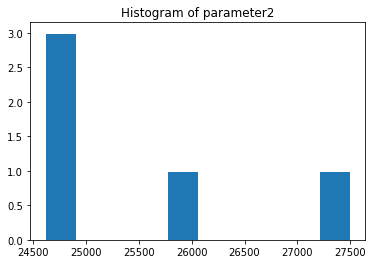

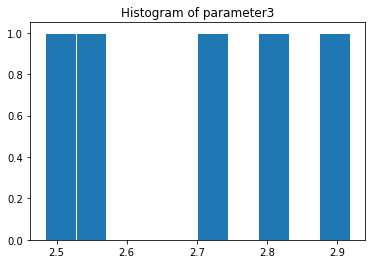

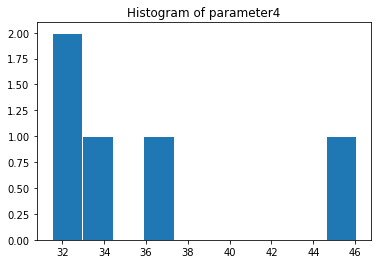

In [ ]:
for k in range(len(epsilons)):
    for j in range(len(params_tumor)):
        plt.figure()
        b=[]
        for i in sample[k,:]:
            b.append(i[j])
        al=np.histogram(b)
        n,bins,patches=plt.hist(b,edgecolor='white')
        plt.title('Histogram of parameter'+str(j))
    plt.show()
plt.show()

In [ ]:
data2=euler_imp(0.00873910890384855,101.71415057196334,24249.373528199347,1.8258347571260147,22.351396168929245)

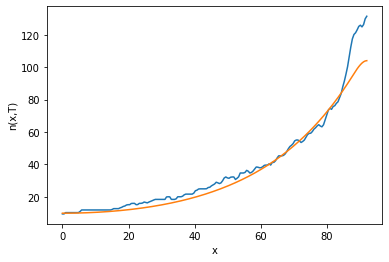

In [ ]:
plt.figure()
plt.plot(x_grid,datosdia6)
plt.plot(x_grid,data2[0:191])
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.show()

In [ ]:
h=0.4819
c2=(9.42*10**(-2))
def euler_impl(Dn,Dc,am,c1,betaf):
  x0=data4
  it_anterior=x0
  x=x0
  k=1000
  zx=np.zeros(382)
  tfinal=259200; #%tiempo final al que quiero llegar (2 dias)
  k=1000; #%tamano de paso del metodo. Cada paso son 6 segundos

  nsteps=round((1/k)*tfinal); #%VOY A DAR 867 pasos

  func=lambda x: x-k*eval_function(x,Dn,Dc,c1,am,betaf)-it_anterior

  for i in range(0,nsteps):
    zx=fsolve(func,it_anterior)
    it_anterior=zx
  return(zx)


In [ ]:
data3=euler_impl(0.00873910890384855,101.71415057196334,24249.373528199347,1.8258347571260147,22.351396168929245)

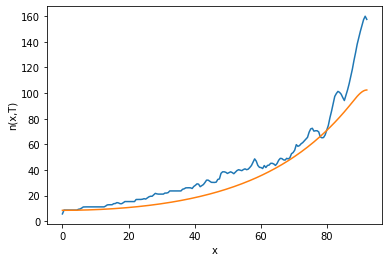

In [ ]:
plt.figure()
plt.plot(x_grid,datosdia9)
plt.plot(x_grid,data3[0:191])
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.show()

In [ ]:
data4=euler_imp(0.006066950183550362,146.79606476000794,21713.805172516404,2.739918202870899,24.759673174062115)

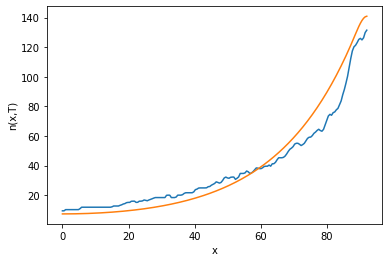

In [ ]:
plt.figure()
plt.plot(x_grid,datosdia6)
plt.plot(x_grid,data4[0:191])
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.show()

In [ ]:
data5=euler_impl(0.006066950183550362,146.79606476000794,21713.805172516404,2.739918202870899,24.759673174062115)

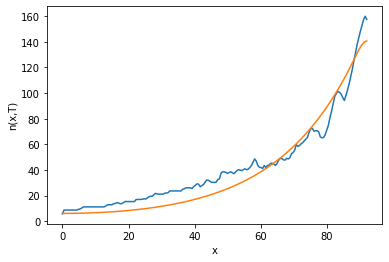

In [ ]:
plt.figure()
plt.plot(x_grid,datosdia9)
plt.plot(x_grid,data5[0:191])
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.show()